IMPORTING SALIENT LIBRARIES

In [ ]:
import os 
import zipfile
import pandas as pd
import numpy as np
from tensorflow import keras

DATA FETCHING AND EXTRACTING

The climate change data is fetched from the World Bank API with the help of keras.utils. It is then extracted to get the csv files containing the salient data

In [ ]:
url = "https://api.worldbank.org/v2/en/topic/19?downloadformat=csv" # data repository

# a function for downloading and etxracting data
def download_extract_data():
  download_path = os.path.join(os.getcwd(),"data/data.tar.gz") # path for storing the data's zip file
  # fetching the data
  if not os.path.exists("data"):
    os.makedirs("data")
    keras.utils.get_file(download_path,url)
  # Extracting the data
  if not os.path.exists("data/API_19_DS2_en_csv_v2_4028487.csv"):
    basepath = os.path.join(os.getcwd(),"data")
    with zipfile.ZipFile(download_path, "r") as zp:
      zp.extractall(basepath)


download_extract_data()

3809280/3796908 [==============================] - 0s 0us/step


DATA PREPARATION

We are using Pandas for manipulating the csv file. We skip the first four rows

In [ ]:
climate_change_df = pd.read_csv("data/API_19_DS2_en_csv_v2_4028487.csv", skiprows=4).drop(['Unnamed: 66'], axis=1)

In [ ]:
def normalize(data):
  max = np.max(data)
  normalized = data/max
  return  normalized

POPULATION GROWTH RATE


The population growth rate of all the countries in the world

In [ ]:
pop_growth_ds = climate_change_df[climate_change_df['Indicator Code'] == 'SP.POP.GROW'].drop(['Indicator Code', 'Indicator Name'], axis=1)
pop_growth_ds_filtered = pop_growth_ds.fillna(0)
pop_growth_1990 = pop_growth_ds_filtered['1990'].values
pop_growth_2019 = pop_growth_ds_filtered['2019'].values
pop_growth_ds.head()

CO2 Emissions (kg per PPP $ of GDP)

CO2 emissions measured in kilogram per PPP of Gross Domestic Product of all the countries in the world

In [ ]:
CO2_df = climate_change_df[climate_change_df['Indicator Code'] == 'EN.ATM.CO2E.PP.GD'].fillna(0)
CO2_1990_ds = CO2_df['1990'].values
CO2_2015_ds = CO2_df['2015'].values

KMeans Clustering

It is a clustering algorithm which involves assigning examples to clusters in an effort to minimize the variance within each cluster. It is one of the most widely used clustering algorithm for unsupervised learning .

In [ ]:
from sklearn.cluster import KMeans, OPTICS
from matplotlib import pyplot as plt 

 
def reshape(groupA, groupB):
  xy = np.empty((266, 2))
  for index, (i,j) in enumerate(zip(groupA, groupB)):
    xy[index, 0] = i
    xy[index, 1] = j
  return xy

# A function for finding KMeans clusters
def cluster_KMeans(data):
  model =  KMeans(n_clusters=5, random_state=0)
  data_pred = model.fit_predict(data)
  data_pred_unique = np.unique(data_pred)
  return data_pred, data_pred_unique

# A function for finding OPTICS clusters
def cluster_OPTICS(data):
  model =  OPTICS(eps=0.8,min_samples=10)
  data_pred = model.fit_predict(data)
  data_pred_unique = np.unique(data_pred)
  return data_pred, data_pred_unique

# A function for plotting clusters 
def plot_clusters(clusters,predicted, combined, title, xlabel, ylabel):
  for cluster in clusters:
    # get row indexes for samples with this cluster
    row_ix = np.where(predicted == cluster)
    # create scatter of these samples
    plt.scatter(combined[row_ix, 0], combined[row_ix, 1])
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
  # show the plot
  plt.show()

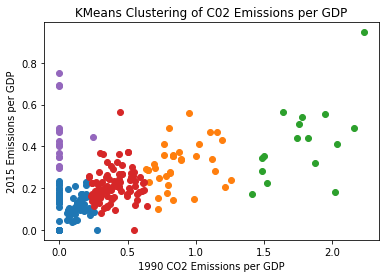

In [17]:
C02_combined = reshape(CO2_1990_ds, CO2_2015_ds)
CO2_combined_hat = cluster_KMeans(C02_combined)[0]
CO2_combined_clusters = cluster_KMeans(C02_combined)[1]
plot_clusters(
        CO2_combined_clusters, 
        CO2_combined_hat, 
        C02_combined, 
        "KMeans Clustering of C02 Emissions per GDP", 
        "1990 CO2 Emissions per GDP", 
        "2015 Emissions per GDP")

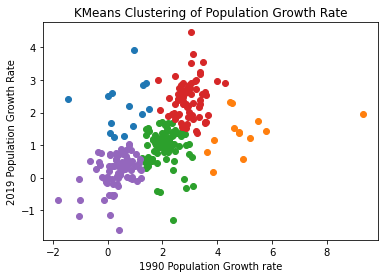

In [ ]:
pop_growth_1990_2019 = reshape(pop_growth_1990, pop_growth_2019)
pop_growth_hat = cluster_KMeans(pop_growth_1990_2019)[0]
pop_growth_clusters = cluster_KMeans(pop_growth_1990_2019)[1]
# Visualize the population growth rate clusters
plot_clusters(
        pop_growth_clusters, 
        pop_growth_hat, 
        pop_growth_1990_2019, 
        "KMeans Clustering of Population Growth Rate", 
        "1990 Population Growth rate", 
        "2019 Population Growth Rate")

OPTICS(Ordering Points To Identify the Clustering Structure) Clustering

A clustering Algorithm which does not produce a clustering of a data set explicitly; but instead creates an augmented ordering of the database representing its density-based clustering structure. This cluster-ordering contains information which is equivalent to the density-based clusterings corresponding to a broad range of parameter settings.

In [ ]:
def cluster_OPTICS(data):
  model =  OPTICS(eps=0.8,min_samples=5)
  data_pred = model.fit_predict(data)
  data_pred_unique = np.unique(data_pred)
  return data_pred, data_pred_unique

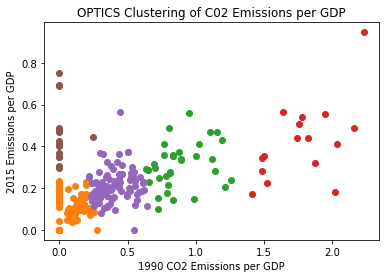

In [ ]:
CO2_combined_hat_z = cluster_KMeans(C02_combined)[0]
CO2_combined_clusters_z = cluster_OPTICS(C02_combined)[1]
plot_clusters(
        CO2_combined_clusters_z, 
        CO2_combined_hat_z, 
        C02_combined, 
        "OPTICS Clustering of C02 Emissions per GDP", 
        "1990 CO2 Emissions per GDP", 
        "2015 Emissions per GDP")

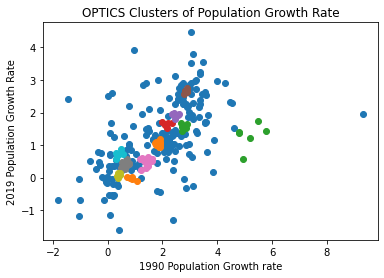

In [ ]:
pop_growth_hat_z = cluster_OPTICS(pop_growth_1990_2019)[0]
pop_growth_clusters_z = cluster_OPTICS(pop_growth_1990_2019)[1]

# Visualize the population growth rate clusters
plot_clusters(
        pop_growth_clusters_z, 
        pop_growth_hat_z, 
        pop_growth_1990_2019, 
        "OPTICS Clusters of Population Growth Rate", 
        "1990 Population Growth rate", 
        "2019 Population Growth Rate")

Part II

Curve Fitting

This is the process of finding the best function which fits depend variable to an independent variable. We are using the population growth rate time series in this case for a clear illustration of curve fitting.

/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


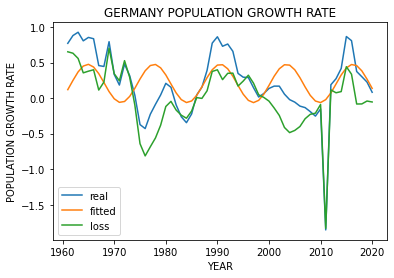

In [ ]:
from scipy.optimize import curve_fit

# PREPARING THE TIME SERIES DATA ON POPULATION GROWTH OF THREE COUNTRIES
DEU_pop_growth = pop_growth_ds[pop_growth_ds['Country Name'] == 'Germany'].drop(['Country Name', 'Country Code'], axis=1).values[0][1:61]
BRA_pop_growth = pop_growth_ds[pop_growth_ds['Country Name'] == 'Brazil'].drop(['Country Name', 'Country Code'], axis=1).values[0][1:61]
CHN_pop_growth = pop_growth_ds[pop_growth_ds['Country Name'] == 'China'].drop(['Country Name', 'Country Code'], axis=1).values[0][1:61]

years = np.arange(1961,2021,1)
years_10 = np.arange(2022,2033, 1)

# Define an objective function for population growth rate of Germany
def objective_DEU(x, a, b, c, d, e):
	return a*np.sin(b*x-c) + x**d 

# Define an objective function for population growth rate of BRAZIL
def objective_BRA(x,a,b):
  return a*x + b

# A function for calculating the error between the real and predicted value
def get_loss(y, ypred):
  return y-ypred

# fitting to find the best curve for Germany Population Growth
def fit_DEU(x, y):
  popt, _ = curve_fit(objective_DEU, years, DEU_pop_growth)
  a, b, c, d, e= popt
  y_fitted = objective_DEU(years, a, b, c, d, e)
  return y_fitted

# fitting to find the best curve for Brazil Population Growth Rate
def fit_BRA(x, y):
  popt, _ = curve_fit(objective_BRA, years, DEU_pop_growth)
  a, b = popt
  y_fitted = objective_BRA(years, a, b)
  return y_fitted

# fitted population growth rate for Germany
DEU_population_fitted = fit_DEU(years, DEU_pop_growth)
# fitted population growth rate for Brazil
BRA_population_fitted = fit_BRA(years, BRA_pop_growth)

 
def plot_lines(
        x, 
        y, 
        yhat, 
        title, 
        xlabel, 
        ylabel, label1="real", label2="fitted", label3="loss"):
  loss = get_loss(y, yhat)
  fig,ax = plt.subplots()
  ax.set_title(title)
  ax.set_xlabel(xlabel)
  ax.set_ylabel(ylabel)
  ax.plot(x,y,'C0', label=label1)
  ax.plot(x, yhat, 'C1', label=label2)
  ax.plot(x, loss, 'C2', label=label3)
  plt.legend()
  plt.show()

plot_lines(
    years, 
    DEU_pop_growth, 
    DEU_population_fitted, 
    "GERMANY POPULATION GROWTH RATE", 
    "YEAR", 
    "POPULATION GROWTH RATE")

ERROR RANGES FOR POPULATION GROWTH RATE

We choose Germany for the sake of brevity

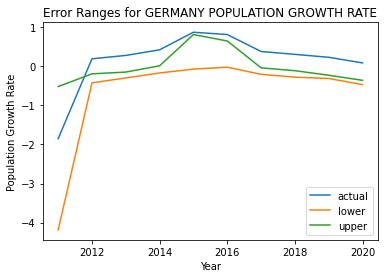

In [19]:
def plot_limits(
        x, 
        y, 
        lower,
        upper, 
        title, 
        xlabel, 
        ylabel, label1="actual", label2="lower", label3="upper"):
  fig,ax = plt.subplots()
  ax.set_title(title)
  ax.set_xlabel(xlabel)
  ax.set_ylabel(ylabel)
  ax.plot(x,y,'C0', label=label1)
  ax.plot(x, lower, 'C1', label=label2)
  ax.plot(x, upper, 'C2', label=label3)
  plt.legend()
  plt.show()


sigma_DEU = get_loss(DEU_pop_growth[-10:], DEU_population_fitted[-10:]) # actual minus fitted curve values for Germany Population Growth Rate

# A fuction for calculating upper and lower limits 
def err_ranges(x, func, param, sigma):
    """
    Calculates the error ranges for the function, parameters and
    sigmas for single value or array x. Functions values are calculated for 
    all combinations of +/- sigma and the minimum and maximum is determined.
    Can be used for all number of parameters and sigmas >=1.
    
    This routine can be used in assignment programs.
    """

    import itertools as iter
    
    # initiate arrays for lower and upper limits
    lower = func(x, *param)
    upper = lower
    
    uplow = []   # list to hold upper and lower limits for parameters
    for p,s in zip(param, sigma):
        pmin = p - s
        pmax = p + s
        uplow.append((pmin, pmax))
        
    pmix = list(iter.product(*uplow))
    
    for p in pmix:
        y = func(x, *p)
        lower = np.minimum(lower, y)
        upper = np.maximum(upper, y)
    
    plot_limits(
            years[-10:], 
            param, 
            lower, 
            upper, 
            "Error Ranges for GERMANY POPULATION GROWTH RATE", 
            "Year", 
            "Population Growth Rate" )   
    return lower, upper

# A function for calculating the lower limits
def func(x, *args):
  lower_vals = []
  for arg in args:
    lower_vals.append(arg-x)
  return lower_vals

offset = 0.5

lower_DEU, upper_DEU = err_ranges(offset, func, DEU_pop_growth[-10:], sigma_DEU)

CONFIDENCE INTERVAL

This is calculated to see how well the best curve of fit matches with the original curve. We will use the population growth rate of Germany for this case

In [ ]:
import scipy.stats as st

def evaluate(y, ypred):
  interval = st.norm.interval(alpha=0.99, loc=np.mean(y), scale=st.sem(y))
  pred_mean = np.mean(ypred)
  passed = False
  if pred_mean>=interval[0] and pred_mean<=interval[1]:
    passed = True
  return passed, pred_mean, interval

evaluate(DEU_pop_growth, DEU_population_fitted)

(True, 0.22151469160023537, (0.06786220963302861, 0.3749922308011062))

COMPARATIVE FITTING OF THREE COUNTRIES

The population growth rate of different countries follow different curves. This means that different factors affect different countries in different ways. For example the political goodwill of a nation like Germany is far better than that of Brazil thus affecting how lifestyles of citizens are led. The growth rate of Germany follows a sinuisoidal curve while that of Brazil follows a nearly linear curve

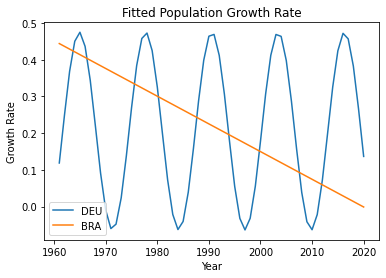

In [ ]:
def plot_two_lines(
        x, 
        y1, 
        y2, 
        title, 
        xlabel, 
        ylabel, label1, label2):
  fig,ax = plt.subplots()
  ax.set_title(title)
  ax.set_xlabel(xlabel)
  ax.set_ylabel(ylabel)
  ax.plot(x,y1,'C0', label=label1)
  ax.plot(x, y2, 'C1', label=label2)
  plt.legend()
  plt.show()

plot_two_lines(
    years, 
    DEU_population_fitted, 
    BRA_population_fitted, 
    "Fitted Population Growth Rate", 
    "Year", 
    "Growth Rate", "DEU", "BRA")